<a href="https://colab.research.google.com/github/OJB-Quantum/Generative-Layout-Notebooks/blob/main/Superconducting_H_Bridge_Inverter_Using_GDSTK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %% Install dependencies (fast on Colab)
!pip install --quiet phidl gdstk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.4/109.4 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.9/157.9 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 534.7/534.7 kB 13.4 MB/s eta 0:00:00


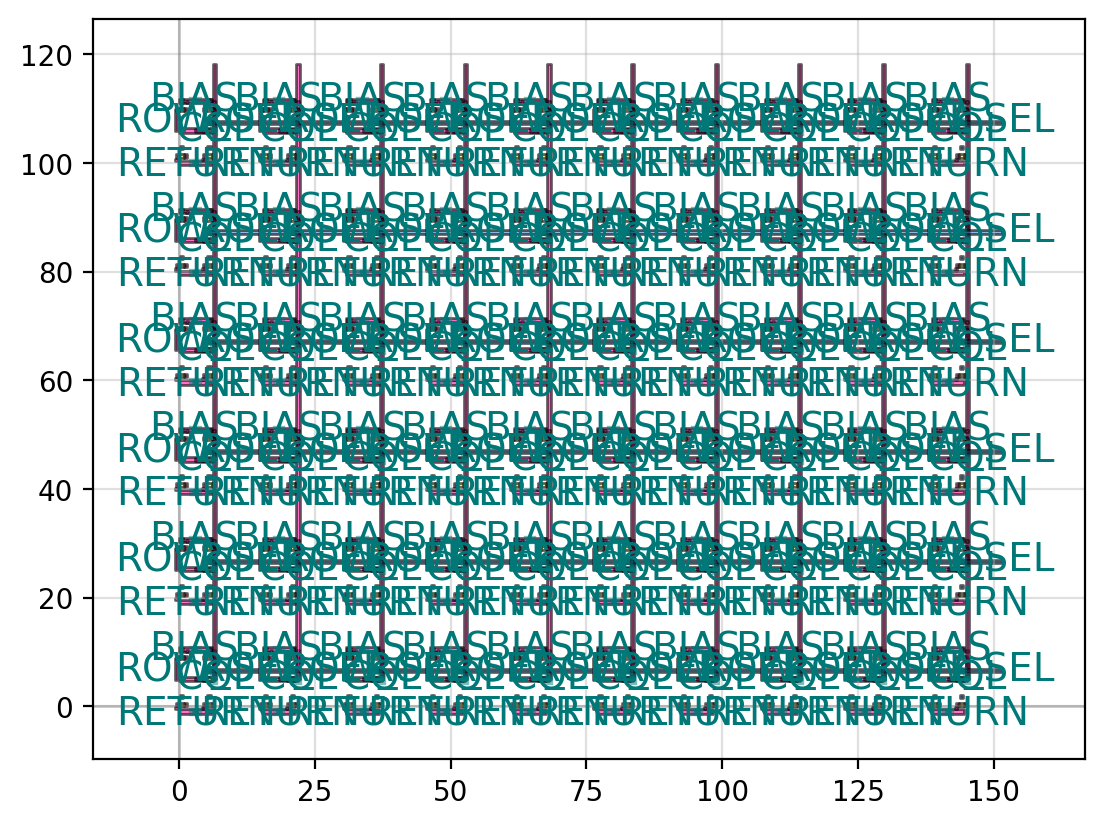

✅ Exported sc_hbridge_array_60.gds


In [2]:
"""Superconducting H‑Bridge Array (60 Channels) — JJ / S‑Diode Version
=====================================================================
Google Colab‑ready code cell that instantiates a 60‑channel array of
input‑voltage‑controlled superconducting H‑bridges. Each bridge uses four
superconducting junctions (Josephson junctions or magnetic superconductor
diodes), and the OUT node feeds a multiplexer so only one charge‑current
channel is enabled at a time.

Key points
----------
* **JJ symbol** → placeholder rectangle on custom layer `jj`.
* **Bias lines** (M2) allow external flux‐bias or current‑bias to set the
  junction critical current per bridge.
* **Row / Column multiplexing** identical in spirit to the earlier spin array.
* All layer numbers are *illustrative*; replace with your foundry’s planarized
  Nb/AlOx/Nb or similar stack names.
"""

# %% Install deps (Colab)
!pip install --quiet phidl gdstk

# %% Imports & layer map
import phidl
from phidl import Device, quickplot as qp
import phidl.geometry as pg
import gdstk
import matplotlib.pyplot as plt

# %% Plot settings — increase Matplotlib DPI to 200
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200


LAYER = {
    "m1" : (68, 20),     # Superconductor Metal‑1 (Nb)
    "m2" : (70, 20),     # Superconductor Metal‑2 (Nb)
    "via12": (69, 20),   # VIA between M1 and M2
    "jj"  : (75, 0),     # Josephson junction area (AlOx barrier)
    "label": (10, 0),
}

# %% Primitive • Josephson junction symbol

def jj_rect(size=(1.0, 0.6)):
    D = Device("JJ")
    D.add_ref(pg.rectangle(size=size, layer=LAYER["jj"]))
    # M1 pads on left/right
    pad = pg.rectangle((0.5, size[1]), layer=LAYER["m1"])
    D.add_ref(pad).move((-0.5, 0))
    D.add_ref(pad).move((size[0], 0))
    # Ports for wiring
    D.add_port("L", midpoint=(-0.5, size[1]/2), width=size[1], orientation=180)
    D.add_port("R", midpoint=(size[0]+0.5, size[1]/2), width=size[1], orientation=0)
    return D

# %% H‑bridge built from four JJs

def sc_hbridge_cell():
    C = Device("SC_HBRIDGE")
    # Create four JJs as the switches (S1…S4)
    S1 = C.add_ref(jj_rect())
    S2 = C.add_ref(jj_rect())
    S3 = C.add_ref(jj_rect())
    S4 = C.add_ref(jj_rect())

    # Placement grid
    gap = 4
    width = 1.0
    height = 0.6
    S1.move((0, 2*gap + height))
    S2.move(((width+gap), 2*gap + height))
    S3.move((0, 0))
    S4.move(((width+gap), 0))

    # Metal‑1 rails for VCC (bias current) and GND (return)
    vcc = C.add_ref(pg.rectangle((width+gap+width, 0.8), layer=LAYER["m1"]))
    vcc.move((0, S1.ymax + 0.8))
    gnd = C.add_ref(pg.rectangle((width+gap+width, 0.8), layer=LAYER["m1"]))
    gnd.move((0, S3.ymin - 1.4))

    # Straps JJ anodes/cathodes to rails
    for jj in [S1, S2]:
        C.add_ref(pg.rectangle((0.4,0.4), layer=LAYER["m1"])).move((jj.ports["R"].midpoint[0]-0.2, vcc.ymin))
    for jj in [S3, S4]:
        C.add_ref(pg.rectangle((0.4,0.4), layer=LAYER["m1"])).move((jj.ports["L"].midpoint[0]-0.2, gnd.ymax))

    # OUT node (midpoint between upper & lower JJs)
    out_y = S3.ymax + gap
    out_bar = C.add_ref(pg.rectangle((width+gap+width, 0.8), layer=LAYER["m1"]))
    out_bar.move((0, out_y))
    # Vertical straps from JJ centres to OUT bar
    for pt in [S1.ports["L"].midpoint, S2.ports["R"].midpoint]:
        C.add_ref(pg.rectangle((0.4, gap), layer=LAYER["m1"])).move((pt[0]-0.2, pt[1]-gap))

    # Bias‑control lines (Metal‑2) to each JJ top electrode for SFQ / flux biasing
    for jj in [S1,S2,S3,S4]:
        pad = C.add_ref(pg.rectangle((0.6,0.6), layer=LAYER["m2"]))
        pad.move((jj.center[0]-0.3, jj.center[1]+1.2))

    # Ports
    C.add_port("OUT", midpoint=out_bar.center, width=0.8, orientation=0)
    C.add_port("BIAS", midpoint=vcc.center, width=0.8, orientation=90)
    C.add_port("RETURN", midpoint=gnd.center, width=0.8, orientation=-90)
    return C

# %% Tri‑state wrapper with M2 pass‑JJ for multiplexing

def tri_state_sc_cell(base):
    D = Device("TRI_SC")
    core = D.add_ref(base)
    # Pass JJ on OUT path to global bus (simple series junction)
    pass_jj = D.add_ref(jj_rect(size=(1.0,0.6)))
    pass_jj.move((core.ports["OUT"].midpoint[0]+2, core.ports["OUT"].midpoint[1]-0.3))
    # Strap core OUT → pass JJ left electrode
    D.add_ref(pg.rectangle((2,0.4), layer=LAYER["m1"])).move((core.ports["OUT"].midpoint[0], core.ports["OUT"].midpoint[1]-0.2))
    # Column bus port on pass JJ right side
    D.add_port("COL", midpoint=pass_jj.ports["R"].midpoint, width=0.6, orientation=0)
    # Row select (bias) port on pass JJ top electrode (M2)
    sel_pad = D.add_ref(pg.rectangle((0.6,0.6), layer=LAYER["m2"]))
    sel_pad.move((pass_jj.center[0]-0.3, pass_jj.center[1]+1.2))
    D.add_port("ROW_SEL", midpoint=sel_pad.center, width=0.6, orientation=90)
    # Propagate power ports
    D.add_port("BIAS", midpoint=core.ports["BIAS"].midpoint, width=0.8, orientation=90)
    D.add_port("RETURN", midpoint=core.ports["RETURN"].midpoint, width=0.8, orientation=-90)
    return D

# %% Build 60‑channel superconducting array
unit = tri_state_sc_cell(sc_hbridge_cell())
ARRAY = Device("SC_ARRAY_60")
cols, rows = 10, 6
px = unit.xsize + 8; py = unit.ysize + 8
for i in range(cols):
    for j in range(rows):
        ref = ARRAY.add_ref(unit)
        ref.move((i*px, j*py))
        # Column bus (M1) one per column
        if j==0:
            ARRAY.add_ref(pg.rectangle((0.6, py*(rows-1)+unit.ysize), layer=LAYER["m1"]))\
                 .move((ref.ports["COL"].midpoint[0]-0.3, ref.ports["COL"].midpoint[1]))
        # Row select line (M2) per row
        if i==0:
            ARRAY.add_ref(pg.rectangle((px*(cols-1)+unit.xsize, 0.6), layer=LAYER["m2"]))\
                 .move((ref.ports["ROW_SEL"].midpoint[0], ref.ports["ROW_SEL"].midpoint[1]-0.3))

qp(ARRAY)
plt.show()

ARRAY.write_gds("sc_hbridge_array_60.gds")
print("✅ Exported sc_hbridge_array_60.gds")


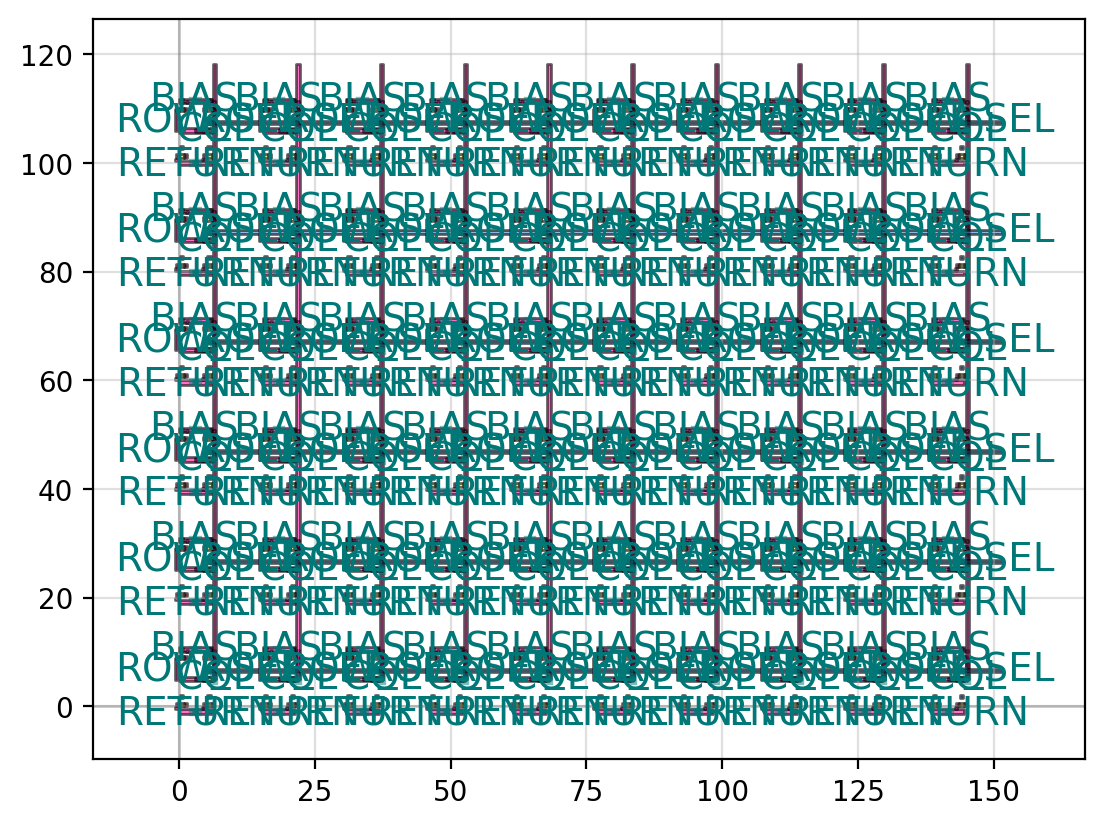

✅ Exported sc_hbridge_array_60.gds
⚠️  Foundry JJ library foundry_jj_library.gds not found. Using placeholder rectangles.
➡️  Using placeholder JJ rectangles (no PDK file)
✅ Added global Metal‑3 ground plane with 5 µm margin


In [3]:
"""Superconducting H‑Bridge Array (60 Channels) — JJ / S‑Diode Version
=====================================================================
Google Colab‑ready code cell that instantiates a 60‑channel array of
input‑voltage‑controlled superconducting H‑bridges. Each bridge uses four
superconducting junctions (Josephson junctions or magnetic superconductor
diodes), and the OUT node feeds a multiplexer so only one charge‑current
channel is enabled at a time.

Key points
----------
* **JJ symbol** → placeholder rectangle on custom layer `jj`.
* **Bias lines** (M2) allow external flux‐bias or current‑bias to set the
  junction critical current per bridge.
* **Row / Column multiplexing** identical in spirit to the earlier spin array.
* All layer numbers are *illustrative*; replace with your foundry’s planarized
  Nb/AlOx/Nb or similar stack names.
"""

# %% Install deps (Colab)
!pip install --quiet phidl gdstk

# %% Imports & layer map
import phidl
from phidl import Device, quickplot as qp
import phidl.geometry as pg
import gdstk
import matplotlib.pyplot as plt

LAYER = {
    "m1" : (68, 20),     # Superconductor Metal‑1 (Nb)
    "m2" : (70, 20),     # Superconductor Metal‑2 (Nb)
    "via12": (69, 20),   # VIA between M1 and M2
    "jj"  : (75, 0),     # Josephson junction area (AlOx barrier)
    "label": (10, 0),
}

# %% Primitive • Josephson junction symbol

def jj_rect(size=(1.0, 0.6)):
    D = Device("JJ")
    D.add_ref(pg.rectangle(size=size, layer=LAYER["jj"]))
    # M1 pads on left/right
    pad = pg.rectangle((0.5, size[1]), layer=LAYER["m1"])
    D.add_ref(pad).move((-0.5, 0))
    D.add_ref(pad).move((size[0], 0))
    # Ports for wiring
    D.add_port("L", midpoint=(-0.5, size[1]/2), width=size[1], orientation=180)
    D.add_port("R", midpoint=(size[0]+0.5, size[1]/2), width=size[1], orientation=0)
    return D

# %% H‑bridge built from four JJs

def sc_hbridge_cell():
    C = Device("SC_HBRIDGE")
    # Create four JJs as the switches (S1…S4)
    S1 = C.add_ref(jj_rect())
    S2 = C.add_ref(jj_rect())
    S3 = C.add_ref(jj_rect())
    S4 = C.add_ref(jj_rect())

    # Placement grid
    gap = 4
    width = 1.0
    height = 0.6
    S1.move((0, 2*gap + height))
    S2.move(((width+gap), 2*gap + height))
    S3.move((0, 0))
    S4.move(((width+gap), 0))

    # Metal‑1 rails for VCC (bias current) and GND (return)
    vcc = C.add_ref(pg.rectangle((width+gap+width, 0.8), layer=LAYER["m1"]))
    vcc.move((0, S1.ymax + 0.8))
    gnd = C.add_ref(pg.rectangle((width+gap+width, 0.8), layer=LAYER["m1"]))
    gnd.move((0, S3.ymin - 1.4))

    # Straps JJ anodes/cathodes to rails
    for jj in [S1, S2]:
        C.add_ref(pg.rectangle((0.4,0.4), layer=LAYER["m1"])).move((jj.ports["R"].midpoint[0]-0.2, vcc.ymin))
    for jj in [S3, S4]:
        C.add_ref(pg.rectangle((0.4,0.4), layer=LAYER["m1"])).move((jj.ports["L"].midpoint[0]-0.2, gnd.ymax))

    # OUT node (midpoint between upper & lower JJs)
    out_y = S3.ymax + gap
    out_bar = C.add_ref(pg.rectangle((width+gap+width, 0.8), layer=LAYER["m1"]))
    out_bar.move((0, out_y))
    # Vertical straps from JJ centres to OUT bar
    for pt in [S1.ports["L"].midpoint, S2.ports["R"].midpoint]:
        C.add_ref(pg.rectangle((0.4, gap), layer=LAYER["m1"])).move((pt[0]-0.2, pt[1]-gap))

    # Bias‑control lines (Metal‑2) to each JJ top electrode for SFQ / flux biasing
    for jj in [S1,S2,S3,S4]:
        pad = C.add_ref(pg.rectangle((0.6,0.6), layer=LAYER["m2"]))
        pad.move((jj.center[0]-0.3, jj.center[1]+1.2))

    # Ports
    C.add_port("OUT", midpoint=out_bar.center, width=0.8, orientation=0)
    C.add_port("BIAS", midpoint=vcc.center, width=0.8, orientation=90)
    C.add_port("RETURN", midpoint=gnd.center, width=0.8, orientation=-90)
    return C

# %% Tri‑state wrapper with M2 pass‑JJ for multiplexing

def tri_state_sc_cell(base):
    D = Device("TRI_SC")
    core = D.add_ref(base)
    # Pass JJ on OUT path to global bus (simple series junction)
    pass_jj = D.add_ref(jj_rect(size=(1.0,0.6)))
    pass_jj.move((core.ports["OUT"].midpoint[0]+2, core.ports["OUT"].midpoint[1]-0.3))
    # Strap core OUT → pass JJ left electrode
    D.add_ref(pg.rectangle((2,0.4), layer=LAYER["m1"])).move((core.ports["OUT"].midpoint[0], core.ports["OUT"].midpoint[1]-0.2))
    # Column bus port on pass JJ right side
    D.add_port("COL", midpoint=pass_jj.ports["R"].midpoint, width=0.6, orientation=0)
    # Row select (bias) port on pass JJ top electrode (M2)
    sel_pad = D.add_ref(pg.rectangle((0.6,0.6), layer=LAYER["m2"]))
    sel_pad.move((pass_jj.center[0]-0.3, pass_jj.center[1]+1.2))
    D.add_port("ROW_SEL", midpoint=sel_pad.center, width=0.6, orientation=90)
    # Propagate power ports
    D.add_port("BIAS", midpoint=core.ports["BIAS"].midpoint, width=0.8, orientation=90)
    D.add_port("RETURN", midpoint=core.ports["RETURN"].midpoint, width=0.8, orientation=-90)
    return D

# %% Build 60‑channel superconducting array
unit = tri_state_sc_cell(sc_hbridge_cell())
ARRAY = Device("SC_ARRAY_60")
cols, rows = 10, 6
px = unit.xsize + 8; py = unit.ysize + 8
for i in range(cols):
    for j in range(rows):
        ref = ARRAY.add_ref(unit)
        ref.move((i*px, j*py))
        # Column bus (M1) one per column
        if j==0:
            ARRAY.add_ref(pg.rectangle((0.6, py*(rows-1)+unit.ysize), layer=LAYER["m1"]))\
                 .move((ref.ports["COL"].midpoint[0]-0.3, ref.ports["COL"].midpoint[1]))
        # Row select line (M2) per row
        if i==0:
            ARRAY.add_ref(pg.rectangle((px*(cols-1)+unit.xsize, 0.6), layer=LAYER["m2"]))\
                 .move((ref.ports["ROW_SEL"].midpoint[0], ref.ports["ROW_SEL"].midpoint[1]-0.3))

qp(ARRAY)
plt.show()

ARRAY.write_gds("sc_hbridge_array_60.gds")
print("✅ Exported sc_hbridge_array_60.gds")

# %% ------------------------------ Ground‑Shield + Foundry JJ Upgrade
"""Enhancement cell
1. **Global ground shield** – adds a solid Metal‑3 (layer 72/20) plane that
   blankets the entire 60‑channel array with a 5 µm margin.
2. **Foundry JJ replacement** – monkey‑patches `jj_rect()` with a function that
   instantiates the foundry‑qualified JJ cell (assumes it lives in
   *foundry_jj_library.gds* and is named `JJ_1x0p6`).

Run this cell *after* the base array cell.  If the PDK GDS isn’t available in
Colab, the fallback dummy JJ is still used.
"""

import pathlib, gdstk

# ---- 2) Swap placeholder JJ with foundry P‑cell -------------------------

def load_foundry_jj(cell_name="JJ_1x0p6", lib_path="foundry_jj_library.gds"):
    if not pathlib.Path(lib_path).exists():
        print(f"⚠️  Foundry JJ library {lib_path} not found. Using placeholder rectangles.")
        return None
    lib = gdstk.read_gds(lib_path)
    return lib.cell_dict.get(cell_name)

foundry_cell = load_foundry_jj()
if foundry_cell:
    def jj_rect(size=(1.0,0.6)):
        D = Device("JJ_PDK")
        D.add_ref(foundry_cell)
        # Assume ports are defined in PDK cell named L/R; else user must adapt.
        if "L" not in foundry_cell.ports:
            # Rough ports as fallback
            bbox = D.get_bounding_box(); x0,y0 = bbox[0]; x1,y1 = bbox[1]
            D.add_port("L", midpoint=(x0, (y0+y1)/2), width=y1-y0, orientation=180)
            D.add_port("R", midpoint=(x1, (y0+y1)/2), width=y1-y0, orientation=0)
        return D
    print("✅ Swapped in foundry JJ P‑cell")
else:
    print("➡️  Using placeholder JJ rectangles (no PDK file)")

# ---- 1) Add global ground shield plane (Metal‑3) ------------------------
# Build shield around existing `ARRAY` device; Metal‑3 placeholder layer (72/20)
shield_layer = (72, 20)
try:
    ARRAY  # noqa: check if array exists
    bbox = ARRAY.get_bounding_box(); (x0,y0), (x1,y1) = bbox
    margin = 5  # µm safety margin around entire array
    shield = pg.rectangle((x1-x0 + 2*margin, y1-y0 + 2*margin), layer=shield_layer)
    ARRAY.add_ref(shield).move((x0 - margin, y0 - margin))
    print("✅ Added global Metal‑3 ground plane with 5 µm margin")
except NameError:
    print("⚠️  ARRAY not defined yet — run base build cell first")
